# Torchvision object Detection FineTuning Tutorial

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed.zip -d /content/drive/MyDrive/pytorch_tutorial/DATA

Archive:  /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed.zip
   creating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/
  inflating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/added-object-list.txt  
   creating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/Annotation/
  inflating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFudanPed/Annotation/FudanPed00006.txt  
  inflating: /content/drive/MyDrive/pytorch_tutorial/DATA/PennFuda

In [7]:
import os
import numpy as np
import torch
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms): #초기화 매서드
    self.root =root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, idx): # 슬라이싱할때 사용
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = Image.open(img_path).convert("RGB") # mask는 convert X, 색깔의 상관관계때문
    mask = Image.open(mask_path)
    mask = np.array(mask) # numpy로 바꿈
    obj_ids = np.unique(mask) # 다른 색깔로 encoding?
    obj_ids = obj_ids[1:] # 첫번쨰 id는 백그라운드라 제거

    masks = mask == obj_ids[:m, None, None] #집합으로 바꿔줌

    # maks아래 bounding 구하기
    num_objs = len(obj_ids)
    boxes=[]
    for i in range(num_objs):
      pos= np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs, ), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = (boxes[:, 3]- boxes[:, 1])*(boxes[:, 2]- boxes[:, 0])
    iscrowd = torch.zeros((num_objs, ), dtype=torch.int64)
    target = {}
    target['boxes']=boxes
    target['labels']=labels
    target['masks'] = masks
    target['image_id']=image_id
    target['area'] = area
    target['iscrowd']=iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img. target

    def __len__(self):
      return len(self.imgs)



## mask R-CNN 사용 : bounding box예측하고 class score 예측

1. Finetuning from pretrained model

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2 # person/background
# classifier에 대한 input 특징의 수
in_features = model.roi_heads.box_predictor.cls_score.in_features
# pretrained head를 새로운것으로 바꿈
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

2. Modifying the model to add a different backbone

In [14]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

#features만
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# output channels in a backbone
backbone.out_channels = 1280

# RPN generate
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512), ), aspect_ratios=((0.5, 1.0, 2.0), ))
# feature map
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool = roi_pooler)

3. Instance segmentation model

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  # pretrained head 바꿈
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256

  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
  return model

In [29]:
!pip install transforms

  Created wheel for transforms: filename=transforms-0.1-py3-none-any.whl size=39351 sha256=7e74538478d8fc133bee2025aa0003109afca34704d48f8a7b96b41aa7b24f93
  Stored in directory: /root/.cache/pip/wheels/73/8d/26/be8b7e278f01d5093d18fc99c8158bd8528403242c852a558c
Successfully built transforms


In [33]:
!pip install sgmllib

ERROR: Could not find a version that satisfies the requirement sgmllib (from versions: none)
ERROR: No matching distribution found for sgmllib


In [31]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

ModuleNotFoundError: ignored

4. foward()

In [23]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)

images, targets = next(iter(data_loader))
images = list(image for image in images)
targets =[{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

AttributeError: ignored

In [35]:
from engine import train_one_epoch, evaluate
import utils

def main():
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('CPU')
  num_classes = 2

  dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
  dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

  indices = torch.randperm(len(dataset)).tolist()
  dataset = torch.utils.data.Subset(dataset, indices[:-50])
  dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

  data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

  data_loader_test = torch.utils.data.DataLoader(
      dataset_test, batch_size=1, shuffle=False, num_workers=4,
      collate_fn=utils.collate_fn) 
  
  model = get_model_instance_segmentation(num_classes)

  model.to(device)

  params = [p for p in model.parameters() if p.requires_grads]
  optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

  num_epochs=10
  for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

  print("That's it!")


ModuleNotFoundError: ignored

# Transfer learning for computer vision tutorial

In [36]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [ ]:
!unzip /content/drive/MyDrive/pytorch_tutorial/DATA/hymenoptera_data.zip -d /content/drive/MyDrive/pytorch_tutorial/DATA/

In [38]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/pytorch_tutorial/DATA/hymenoptera_data'

image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
for x in ['train', 'val']
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2. 이미지 시각화

In [39]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean=np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std*inp+mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

  inputs, classes = next(iter(dataloaders['train']))
  out = torchvision.utils.make_grid(inputs)
  imshow(out, title=[class_names[x] for x in classes])

3. model train

In [52]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train', 'val']:
      if phase == 'trian':
        model.train()
      else:
        model.eval()

      running_loss  =0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() 

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds==labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))     

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print() 

  time_elapsed = time.time()-since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model 

In [59]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted:{}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [54]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [55]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6887 Acc: 0.6311
val Loss: 0.7014 Acc: 0.4575

Epoch 1/24
----------
train Loss: 0.6958 Acc: 0.4836
val Loss: 0.6924 Acc: 0.4575

Epoch 2/24
----------
train Loss: 0.6905 Acc: 0.5451
val Loss: 0.6888 Acc: 0.5425

Epoch 3/24
----------
train Loss: 0.6907 Acc: 0.5328
val Loss: 0.6852 Acc: 0.5882

Epoch 4/24
----------
train Loss: 0.6719 Acc: 0.5574
val Loss: 0.7088 Acc: 0.6209

Epoch 5/24
----------
train Loss: 0.7099 Acc: 0.4590
val Loss: 0.6933 Acc: 0.4444

Epoch 6/24
----------
train Loss: 0.6935 Acc: 0.5041
val Loss: 0.6913 Acc: 0.5425

Epoch 7/24
----------
train Loss: 0.6920 Acc: 0.5041
val Loss: 0.6916 Acc: 0.5425

Epoch 8/24
----------
train Loss: 0.6914 Acc: 0.5574
val Loss: 0.6920 Acc: 0.5621

Epoch 9/24
----------
train Loss: 0.6919 Acc: 0.5246
val Loss: 0.6912 Acc: 0.5621

Epoch 10/24
----------
train Loss: 0.6899 Acc: 0.5738
val Loss: 0.6909 Acc: 0.5882

Epoch 11/24
----------
train Loss: 0.6895 Acc: 0.5287
val Loss: 0.6903 Acc: 0.5294

Epoch 12/24
----------
t

In [56]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [57]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4299 Acc: 0.7828
val Loss: 0.1649 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.1379 Acc: 0.9549
val Loss: 0.1549 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.1444 Acc: 0.9385
val Loss: 0.1459 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.1595 Acc: 0.9426
val Loss: 0.1486 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.1100 Acc: 0.9467
val Loss: 0.1677 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.0952 Acc: 0.9672
val Loss: 0.1368 Acc: 0.9608

Epoch 6/24
----------


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


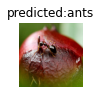

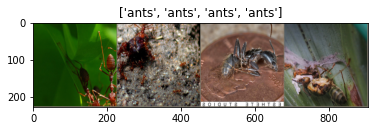

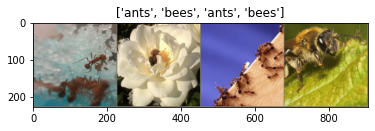

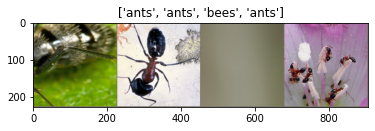

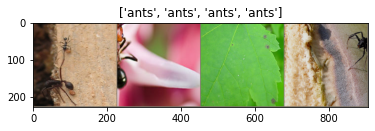

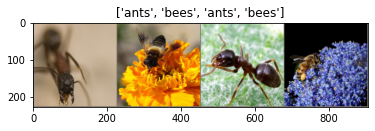

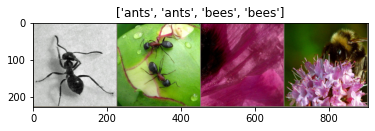

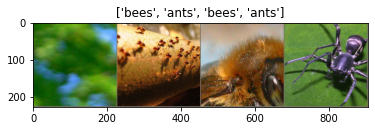

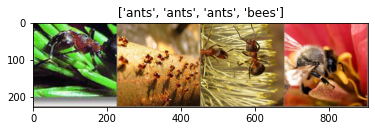

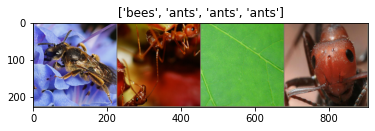

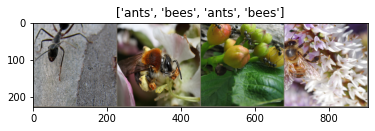

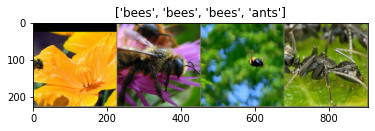

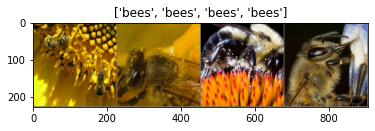

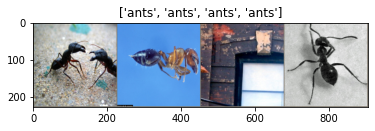

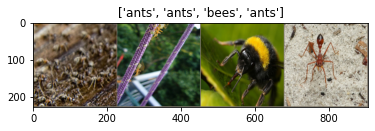

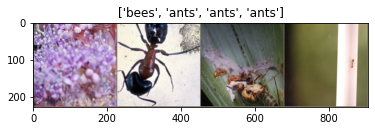

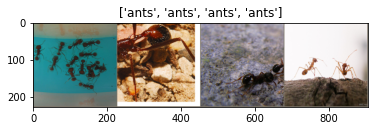

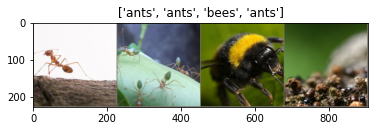

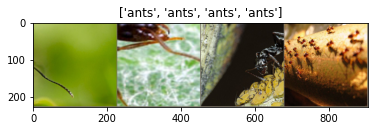

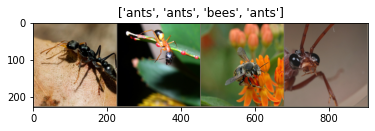

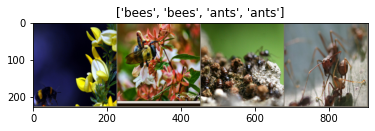

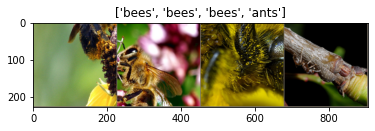

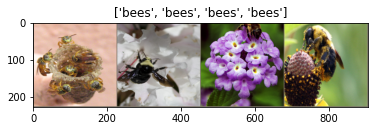

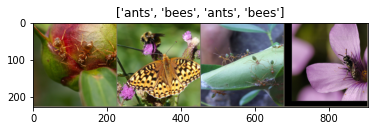

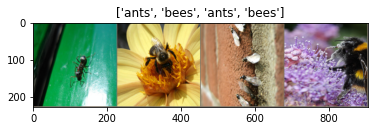

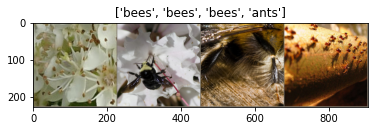

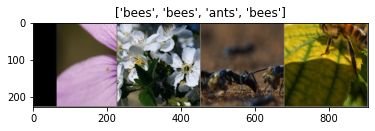

KeyboardInterrupt: ignored

In [60]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# ADVERSARIAL EXAMPLE GENERATION


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "/content/drive/MyDrive/pytorch_tutorial/DATA/lenet_mnist_model.pth"
use_cuda=True

In [22]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

model.eval()


CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

FGSM ATTACK

In [23]:
def fgsm_attack(image, epsilon, data_grad):
  sign_data_grad = data_grad.sign() # data gradient정보
  perturbed_image = image + epsilon*sign_data_grad # cread perturbed image, 픽셀조정해서
  perturbed_image = torch.clamp(perturbed_image, 0, 1) # 클리핑
  return perturbed_image

In [24]:
def test(model, device, test_loader, epsilon):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)

    data.requires_grad = True #공격에 중요함

    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]

    if init_pred.item() != target.item():
      continue

    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()

    data_grad = data.grad.data

    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    output = model(perturbed_data)

    final_pred=output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1

      if (epsilon == 0) and (len(adv_examples)<5):
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
      else:
        if len(adv_examples)<5:
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [25]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 1 / 10000 = 0.0001
Epsilon: 0.05	Test Accuracy = 1 / 10000 = 0.0001
Epsilon: 0.1	Test Accuracy = 1 / 10000 = 0.0001
Epsilon: 0.15	Test Accuracy = 1 / 10000 = 0.0001
Epsilon: 0.2	Test Accuracy = 1 / 10000 = 0.0001
Epsilon: 0.25	Test Accuracy = 1 / 10000 = 0.0001
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0


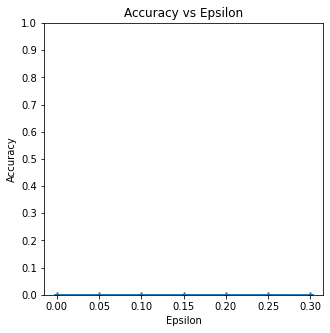

In [26]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

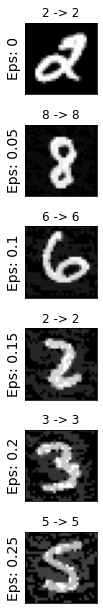

In [27]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# DCGAN

In [28]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


- input

1. dataroot : 데이터 세트 루트
2. workers : 작업자 수
3. batch_size : 배치크기
4. image_size : 이미지 크기
5. nc : 이미지 채널 수
6. nz : 잠재 벡터의 길이
7. ngf : 생성기를 통해 전달되는 기능
8. ndf : 판별기를 통해 전파되는 기능
9. num_epochs
10. lr
11. beta1 :adam optimize
12. ngpu : gpu 수

In [29]:
dataroot = "data/celeba"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

가중치 초기화

In [31]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: # conv layer면 이렇게 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1: # batch layer면 이렇게 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

생성자

In [36]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu,
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, input):
      return self.main(input)

In [38]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


판별자

In [39]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [40]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [41]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.

# 판별자 생성자 최적화
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

학습
<br>

1. train Discriminator : 실제 또는 가짜를 올바르게 분류할 확률 최대화
2. train generator : 생성기를 최소화 하여 더 나은 가짜를 만듦

In [42]:
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
      # 판별자 최대화
      netD.zero_grad()
      # 실제 이미지 batch 학습
      real_cpu = data[0].to(device)
      b_size = real_cpu.size(0)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      output = netD(real_cpu).view(-1)
      errD_real = criterion(output, label)
      errD_real.backward()
      D_x = output.mean().item()

      #가짜 이미지 batch학습
      # latent vectors 생성
      noise = torch.randn(b_size, nz, 1, z, device=device)
      # 이미지 생성
      fake = netG(noise)
      label.fill_(fake_label)
      # 판별자로 분류
      output= netD(fake.detach()).view(-1)
      # loss 계산
      errD_fake = criterion(output, label)
      errD_fake.backward()
      D_G_z1=output.mean().item()

      errD=errD_real+errD_fake
      optimizerD.step()

      # 생성자 최소화
      netG.zero_grad()
      label.fill_(real_label) # 가짜 label은 generator에서 진짜 label cost로 사용
      output = netD(fake).view(-1)
      errG = criterion(output, label)
      errG.backward()
      D_G_z2=output.mean().item()

      optimizerG.step()

      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(dataloader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

      

Starting Training Loop...


NameError: ignored

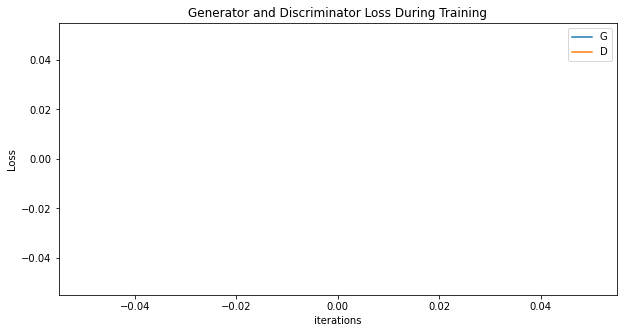

In [43]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

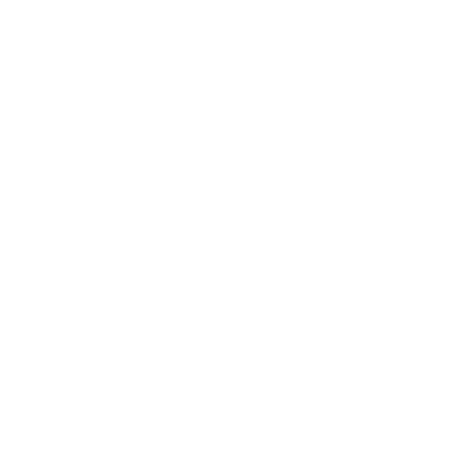

In [44]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# 실제 이미지 선택
real_batch = next(iter(dataloader))
# 실제 이미지
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# 마지막 epoch에서 가짜이미지
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# SPATIAL TRANSFORMER NETWORKS TUTORIAL

In [45]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [46]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


- 공간 변환은 명시적으로 학습되지 않고 대신, 전역 정확도를 상승하는 방향으로 자동으로 학습

- 

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

       # 여기서 localization 진행
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # affine matrix사용
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # 동일한 변환과 함께 weights/bias 초기화
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # localization 네트워크 학습
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        # grid와 smple합침
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # 변환이 input
        x = self.stn(x)

        # 일반 학습 진행
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [49]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [50]:
def convert_image_np(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


In [51]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332479
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.841365


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2236, Accuracy: 9392/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.416498
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.283028

Test set: Average loss: 0.1148, Accuracy: 9653/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.872278
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.264328

Test set: Average loss: 0.1125, Accuracy: 9671/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.338516
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.102506

Test set: Average loss: 0.0750, Accuracy: 9762/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.191937
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.306763

Test set: Average loss: 0.0793, Accuracy: 9757/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.101514
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.095165

Test set: Average loss: 0.0650, Accuracy: 9809/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.144917
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.172358

Test set: Average loss: 0.0812, Accuracy: 9756/10000 (98%)

Tra

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

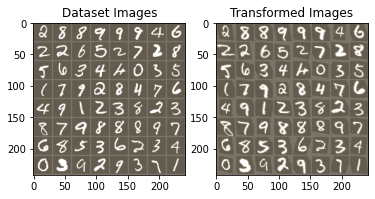

In [52]:
visualize_stn()

plt.ioff()
plt.show()

# OPTIMIZING VISION TRANSFORMER MODEL FOR DEPLOYMENT

DeiT : 데이터 증강, transformer network가 CNN output에서 학습

In [53]:
!pip install torch torchvision timm pandas requests

     |████████████████████████████████| 376 kB 8.1 MB/s 


In [54]:
!pip install timm pandas requests

In [55]:
from PIL import Image
import torch
import timm
import requests
import torchvision.transforms as transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

print(torch.__version__)

1.9.0+cu102


In [56]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()

Downloading: "https://github.com/facebookresearch/deit/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [57]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

img = Image.open(requests.get("https://raw.githubusercontent.com/pytorch/ios-demo-app/master/HelloWorld/HelloWorld/HelloWorld/image.png", stream=True).raw)
img = transform(img)[None,]
out = model(img)
clsidx = torch.argmax(out)
print(clsidx.item())

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


269


폰에도 돌아가게끔 최적화해보자

In [58]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save("fbdeit_scripted.pt")

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Deit 양자화

In [59]:
backend = 'fbgemm' # sever추정에는 fbgemm / 모바일은 qnnpack

model.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine=backend

quantized_model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear},
                                                      dtype=torch.qint8)
scripted_quantized_model = torch.jit.script(quantized_model)
scripted_quantized_model.save("fbdeit_scripted_quantized.pt")

In [60]:
out = scripted_quantized_model(img)
clsidx = torch.argmax(out)
print(clsidx.item())

269


346mb -> 89mb로 용량줄임

Deit 최적화

In [61]:
from torch.utils.mobile_optimizer import optimize_for_mobile
optimized_scripted_quantized_model = optimize_for_mobile(scripted_quantized_model)
optimized_scripted_quantized_model.save("fbdeit_optimized_scripted_quantized.pt")

In [62]:
out = optimized_scripted_quantized_model(img)
clsidx = torch.argmax(out)
print(clsidx.item())

269


lite interpreter 사용 : 얼마다 모델사이즈가 작고 추정이 빠른지

In [63]:
optimized_scripted_quantized_model._save_for_lite_interpreter("fbdeit_optimized_scripted_quantized_lite.ptl")
ptl = torch.jit.load("fbdeit_optimized_scripted_quantized_lite.ptl")

예측 속도 비교

In [64]:
with torch.autograd.profiler.profile(use_cuda=False) as prof1:
    out = model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof2:
    out = scripted_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof3:
    out = scripted_quantized_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof4:
    out = optimized_scripted_quantized_model(img)
with torch.autograd.profiler.profile(use_cuda=False) as prof5:
    out = ptl(img)

print("original model: {:.2f}ms".format(prof1.self_cpu_time_total/1000))
print("scripted model: {:.2f}ms".format(prof2.self_cpu_time_total/1000))
print("scripted & quantized model: {:.2f}ms".format(prof3.self_cpu_time_total/1000))
print("scripted & quantized & optimized model: {:.2f}ms".format(prof4.self_cpu_time_total/1000))
print("lite model: {:.2f}ms".format(prof5.self_cpu_time_total/1000))

original model: 1092.73ms
scripted model: 1324.07ms
scripted & quantized model: 813.36ms
scripted & quantized & optimized model: 589.59ms
lite model: 585.29ms


기존 모델에 비해 절반 가량 예측시간 줄어듦

In [65]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'Model': ['original model','scripted model', 'scripted & quantized model', 'scripted & quantized & optimized model', 'lite model']})
df = pd.concat([df, pd.DataFrame([
    ["{:.2f}ms".format(prof1.self_cpu_time_total/1000), "0%"],
    ["{:.2f}ms".format(prof2.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof2.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof3.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof3.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof4.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof4.self_cpu_time_total)/prof1.self_cpu_time_total*100)],
    ["{:.2f}ms".format(prof5.self_cpu_time_total/1000),
     "{:.2f}%".format((prof1.self_cpu_time_total-prof5.self_cpu_time_total)/prof1.self_cpu_time_total*100)]],
    columns=['Inference Time', 'Reduction'])], axis=1)

print(df)

                                    Model Inference Time Reduction
0                          original model      1092.73ms        0%
1                          scripted model      1324.07ms   -21.17%
2              scripted & quantized model       813.36ms    25.57%
3  scripted & quantized & optimized model       589.59ms    46.04%
4                              lite model       585.29ms    46.44%
